In [1]:
import os
import torch
import numpy as np

import scanpy as sc
from anndata import AnnData

result_dir = "../edges/"
raw_type=False
use_edge=True

In [2]:
sample='mouse1_slice201'
data_dir = "../../data/Mouse_brain/processed/"

In [3]:
def read_data(sample,select=10,loss_threshold=None,normalize=False):
    results=torch.load(result_dir+"edges_"+sample+".pth",map_location=torch.device('cpu'))
    edges=results["attention_score"]
    # modify here
    if normalize:
        attention_score=results["attention_score"]/torch.sum(torch.abs(results["attention_score"]),dim=-2,keepdim=True)
    else:
        attention_score=results["attention_score"]
        normalized_attention_score=results["attention_score"]/torch.sum(results["attention_score"],dim=-2,keepdim=True)
    print(attention_score.shape)
    position_x=results["position_x"]
    position_y=results["position_y"]
    cell_type_name=results["cell_type_name"]
    loss1=results["loss_all"].cpu()
    
    B,N=position_x.shape
    loss1=loss1.unsqueeze(dim=-1).repeat(1,select).reshape(-1).numpy()
    
    cell_type_target=[cell_type_name[i][0] for i in range(len(cell_type_name))]
    
    if normalize:
        indices=torch.topk(torch.sum(attention_score,dim=-1),k=select,dim=-1)[1]
        print(torch.topk(torch.mean(attention_score,dim=-1),k=select,dim=-1))
    else:
        tmp=torch.abs(torch.abs(results["attention_score"])/torch.sum(torch.abs(results["attention_score"]),dim=-2,keepdim=True))
        indices=torch.topk(torch.sum(tmp,dim=-1),k=select,dim=-1)[1]
        print(torch.topk(torch.mean(tmp,dim=-1),k=select,dim=-1))
    indices_tmp=torch.arange(0,indices.shape[0],1).unsqueeze(dim=-1).repeat(1,select)
    indices=torch.stack([indices_tmp.reshape(-1),indices.reshape(-1)],dim=0)

    if not use_edge:
        edges=attention_score
        print("not use edge",edges.shape)
    
    edges=edges[indices[0],indices[1],:].reshape(-1,edges.shape[-1]).numpy()
    attention_score=attention_score[indices[0],indices[1],:].reshape(-1,attention_score.shape[-1]).numpy()
    
    to_position_x=position_x[:,0:1].repeat(1,select).reshape(-1).numpy()
    to_position_y=position_y[:,0:1].repeat(1,select).reshape(-1).numpy()
    from_position_x=position_x[:,1:][indices[0],indices[1]].reshape(-1).numpy()
    from_position_y=position_y[:,1:][indices[0],indices[1]].reshape(-1).numpy()
    
    dx=position_x-position_x[:,0:1]
    dy=position_y-position_y[:,0:1]
    distances=torch.sqrt(torch.square(dx)+torch.square(dy))
    distances=distances[indices[0],indices[1]].reshape(-1).numpy()
    
    indices_np=indices.numpy()
    cell_types=np.array(cell_type_name)[:,1:][indices_np[0],indices_np[1]].reshape(B,select)
    print("number of cell types in this sample:",np.unique(np.array(cell_type_name)[:,0],return_counts=True))
    cell_types_pair=[]
    cell_types_target=[]
    cell_types_from=[]
    flags=[]
    for i in range(cell_types.shape[0]):
        for j in range(cell_types.shape[1]):
            if not raw_type:
                cell_types_pair.append(cell_types[i][j]+"__"+cell_type_target[i])
                flags.append(cell_type_target[i]!=cell_types[i][j])
                cell_types_target.append(cell_type_target[i])
                cell_types_from.append(cell_types[i][j])
            else:
                cell_types_pair.append(cell_types[i][j].split(" ")[0]+"__"+cell_type_target[i].split(" ")[0])
                flags.append(cell_types[i][j].split(" ")[0]!=cell_type_target[i].split(" ")[0])
                cell_types_target.append(cell_type_target[i].split(" ")[0])
                cell_types_from.append(cell_types[i][j].split(" ")[0])

    print(edges.shape)
    adata = AnnData(edges)
    adata.obs['cell_type'] = cell_types_pair
    adata.obs["cell_types_from"]=cell_types_from
    adata.obs['cell_type_target']=cell_types_target
    adata.obs['from_position_x'] = from_position_x
    adata.obs['from_position_y'] = from_position_y
    adata.obs['to_position_x'] = to_position_x
    adata.obs['to_position_y'] = to_position_y
    adata.obs['distance']=distances
    adata.obs['loss']=loss1
    # modify here
    adata.obsm["y"]=results["y"].repeat(1,select).reshape(results["y"].shape[0]*select,results["y"].shape[1]).numpy()
    adata.obsm["attention_score"]=attention_score

    if loss_threshold is None:
        loss_threshold=np.mean(loss1)+np.std(loss1)*2
    adata=adata[(adata.obs['loss']<loss_threshold)&flags,:]
    
    return adata
    
adata=read_data(sample,select=5,normalize=False)
print(adata)

torch.Size([6137, 49, 254])
torch.return_types.topk(
values=tensor([[0.0952, 0.0651, 0.0579, 0.0520, 0.0503],
        [0.1152, 0.0797, 0.0734, 0.0642, 0.0384],
        [0.1059, 0.0697, 0.0667, 0.0576, 0.0554],
        ...,
        [0.0403, 0.0379, 0.0329, 0.0320, 0.0318],
        [0.0525, 0.0496, 0.0479, 0.0457, 0.0354],
        [0.0751, 0.0606, 0.0564, 0.0387, 0.0345]]),
indices=tensor([[31, 26,  0,  2,  6],
        [43, 18, 19,  2,  0],
        [ 0,  1,  2, 45, 36],
        ...,
        [ 5, 10, 39, 20, 22],
        [17,  5, 18, 34, 13],
        [ 8, 14, 44, 35, 29]]))
number of cell types in this sample: (array(['Astro', 'Endo', 'L2/3 IT', 'L4/5 IT', 'L5 ET', 'L5 IT', 'L5/6 NP',
       'L6 CT', 'L6 IT', 'L6 IT Car3', 'L6b', 'Lamp5', 'Micro', 'OPC',
       'Oligo', 'PVM', 'Peri', 'Pvalb', 'SMC', 'Sncg', 'Sst', 'VLMC',
       'Vip', 'other'], dtype='<U10'), array([502, 473, 757, 848, 127, 427,  47, 650, 332,  32,  93,  60, 166,
       121, 551,  91, 172, 162,  89,   6,  73, 180,  50, 

/tmp/ipykernel_2516787/2574720385.py:85: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  adata=adata[(adata.obs['loss']<loss_threshold)&flags,:]


selecting edge types: ['L2/3 IT__L4/5 IT' 'L4/5 IT__L2/3 IT' 'L6 IT__L6 CT' 'L5 IT__L4/5 IT'
 'L5 IT__L6 CT' 'Astro__L2/3 IT' 'L4/5 IT__L5 IT' 'L5 IT__L6 IT'
 'Micro__L2/3 IT' 'L6 IT__L5 IT' 'L2/3 IT__Astro' 'L6 CT__L5 IT'
 'Astro__L4/5 IT' 'L6 CT__Oligo' 'Peri__Endo' 'L6b__L6 CT'
 'Oligo__L4/5 IT' 'Pvalb__L4/5 IT' 'L6b__Oligo' 'Endo__Oligo']


/tmp/ipykernel_2516787/2234844926.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/w

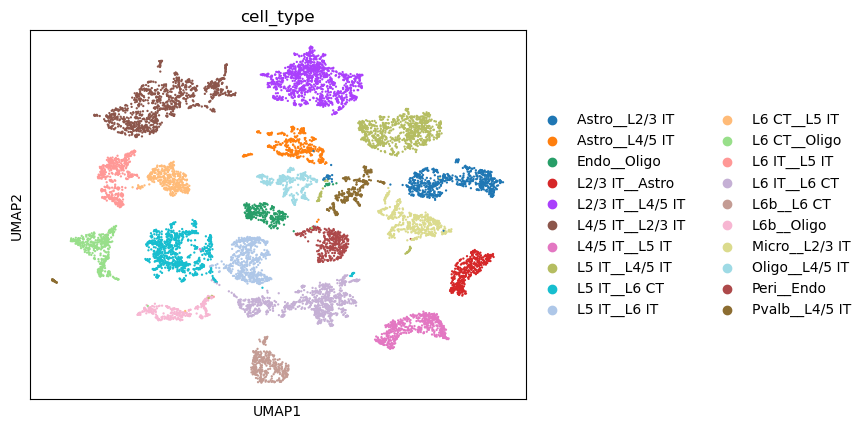

selecting edge types: ['L2/3 IT__L4/5 IT' 'L4/5 IT__L2/3 IT' 'L6 IT__L6 CT' 'L5 IT__L4/5 IT'
 'L5 IT__L6 CT' 'Astro__L2/3 IT' 'L4/5 IT__L5 IT' 'L5 IT__L6 IT'
 'Micro__L2/3 IT' 'L6 IT__L5 IT' 'L2/3 IT__Astro' 'L6 CT__L5 IT'
 'Astro__L4/5 IT' 'L6 CT__Oligo' 'Peri__Endo' 'L6b__L6 CT'
 'Oligo__L4/5 IT' 'Pvalb__L4/5 IT' 'L6b__Oligo' 'Endo__Oligo']


/tmp/ipykernel_2516787/2234844926.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/w

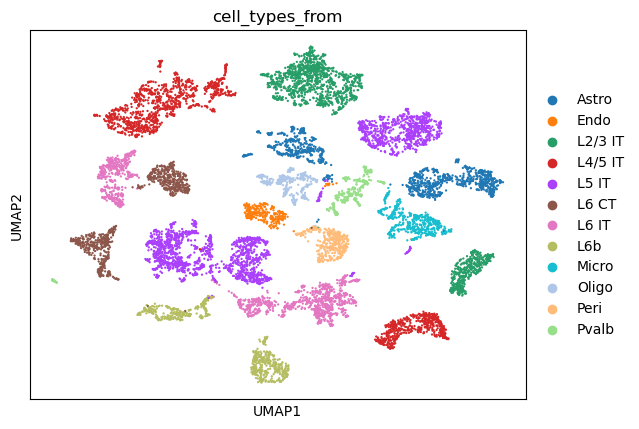

selecting edge types: ['L2/3 IT__L4/5 IT' 'L4/5 IT__L2/3 IT' 'L6 IT__L6 CT' 'L5 IT__L4/5 IT'
 'L5 IT__L6 CT' 'Astro__L2/3 IT' 'L4/5 IT__L5 IT' 'L5 IT__L6 IT'
 'Micro__L2/3 IT' 'L6 IT__L5 IT' 'L2/3 IT__Astro' 'L6 CT__L5 IT'
 'Astro__L4/5 IT' 'L6 CT__Oligo' 'Peri__Endo' 'L6b__L6 CT'
 'Oligo__L4/5 IT' 'Pvalb__L4/5 IT' 'L6b__Oligo' 'Endo__Oligo']


/tmp/ipykernel_2516787/2234844926.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/w

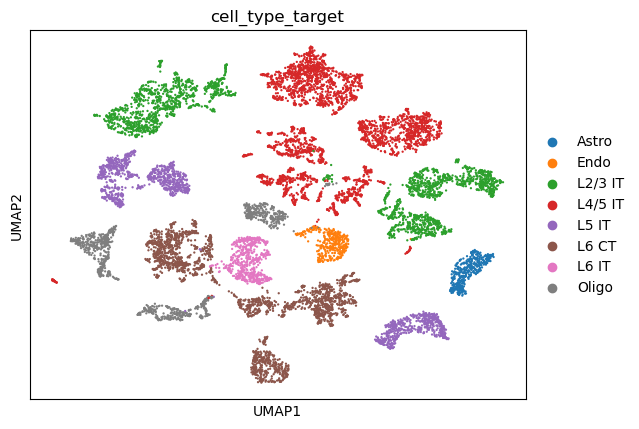

/tmp/ipykernel_2516787/2234844926.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]


selecting edge types: ['L2/3 IT__L4/5 IT' 'L4/5 IT__L2/3 IT' 'L6 IT__L6 CT' 'L5 IT__L4/5 IT'
 'L5 IT__L6 CT' 'Astro__L2/3 IT' 'L4/5 IT__L5 IT' 'L5 IT__L6 IT'
 'Micro__L2/3 IT' 'L6 IT__L5 IT' 'L2/3 IT__Astro' 'L6 CT__L5 IT'
 'Astro__L4/5 IT' 'L6 CT__Oligo' 'Peri__Endo' 'L6b__L6 CT'
 'Oligo__L4/5 IT' 'Pvalb__L4/5 IT' 'L6b__Oligo' 'Endo__Oligo']


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


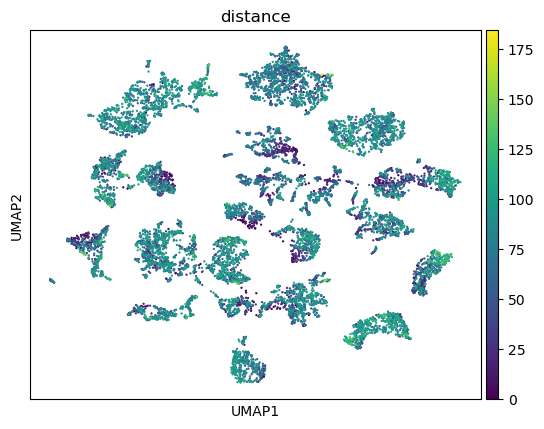

View of AnnData object with n_obs × n_vars = 26583 × 254
    obs: 'cell_type', 'cell_types_from', 'cell_type_target', 'from_position_x', 'from_position_y', 'to_position_x', 'to_position_y', 'distance', 'loss'
    obsm: 'y', 'attention_score'

In [5]:
def plot(adata,color='cell_type',select_type_number=None,select_type=None):
    assert not ((select_type is None and select_type_number is None) and (select_type is not None and select_type_number is not None))
    
    if select_type_number is not None:
        unique=np.unique(adata.obs['cell_type'],return_counts=True)
        args = np.argsort(-unique[1])[:select_type_number]
        select_type = unique[0][args]
    print("selecting edge types:", select_type)
    
    flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
    adata_filtered=adata[flag,:]

    sc.pp.scale(adata_filtered)
    sc.tl.pca(adata_filtered, n_comps=50)
    sc.pp.neighbors(adata_filtered)  # Compute the neighborhood graph
    sc.tl.umap(adata_filtered)  # Compute UMAP
    # Plot UMAP
    sc.pl.umap(adata_filtered, color=color)
    return adata

plot(adata,select_type_number=20)
plot(adata,select_type_number=20,color="cell_types_from")
plot(adata,select_type_number=20,color='cell_type_target')
plot(adata,select_type_number=20,color="distance")

In [5]:
unique=np.unique(adata.obs['cell_type'],return_counts=True)
unique_arg=np.argsort(-unique[1])
print(unique[0][unique_arg].tolist(),unique[1][unique_arg].tolist())

['L2/3 IT__L4/5 IT', 'L4/5 IT__L2/3 IT', 'Astro__L2/3 IT', 'L5 IT__L4/5 IT', 'L4/5 IT__L5 IT', 'L6 IT__L5 IT', 'L6b__L6 CT', 'L5 IT__L6 IT', 'Astro__Oligo', 'L5 IT__L6 CT', 'Endo__Astro', 'L6 IT__L6 CT', 'L6 IT__Oligo', 'Astro__Endo', 'L6 CT__Oligo', 'PVM__Endo', 'L6 CT__L6b', 'L6b__L6 IT', 'L2/3 IT__Astro', 'L4/5 IT__L5 ET', 'Oligo__Astro', 'Astro__L6 CT', 'Sst__L6 CT', 'Pvalb__L6 CT', 'Lamp5__L2/3 IT', 'Astro__other', 'Endo__Oligo', 'Pvalb__Oligo', 'OPC__L2/3 IT', 'L6 CT__L5 IT', 'L5 ET__L6 CT', 'Astro__L6 IT', 'Oligo__L4/5 IT', 'Micro__L2/3 IT', 'L4/5 IT__Pvalb', 'L6 CT__Astro', 'OPC__Oligo', 'Peri__L4/5 IT', 'Peri__Endo', 'OPC__Endo', 'Pvalb__L2/3 IT', 'Oligo__Endo', 'Endo__L4/5 IT', 'Astro__Peri', 'L6 IT Car3__L6 CT', 'L2/3 IT__VLMC', 'L6 IT__Astro', 'Endo__Peri', 'Micro__Endo', 'PVM__VLMC', 'L6 IT__L5 ET', 'L6 CT__Pvalb', 'Endo__PVM', 'Pvalb__Astro', 'Pvalb__Endo', 'Astro__OPC', 'Oligo__VLMC', 'Lamp5__Endo', 'L6 CT__L6 IT', 'Oligo__Peri', 'SMC__Astro', 'Peri__Oligo', 'L5 ET__L4/5

In [6]:
desired_CCC_type='Astro__L2/3 IT'#'Endo__Astro'#'Micro__Endo'#'Astro__Oligo'#'OPC__L2/3 IT'#'Micro__L4/5 IT'#'OPC__L4/5 IT'#'Micro__L4/5 IT','Micro__L6 CT'

def get_type_adata(adata,cell_type_pair):
    flag1=[i==cell_type_pair.split("__")[1] for i in adata.obs['cell_type_target']]
    adata_type=adata[flag1]
    
    flag2=[i==cell_type_pair for i in adata_type.obs['cell_type']]
    adata_type.obs["is_target_interaction"]=flag2
    adata_type.obs["is_target_interaction_str"]=[str(i) for i in flag2]
    print(np.sum(flag2),adata_type.shape[0])
    return adata_type

adata_type=get_type_adata(adata,desired_CCC_type)

1062 3525


/tmp/ipykernel_167492/2224834115.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_type.obs["is_target_interaction"]=flag2


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


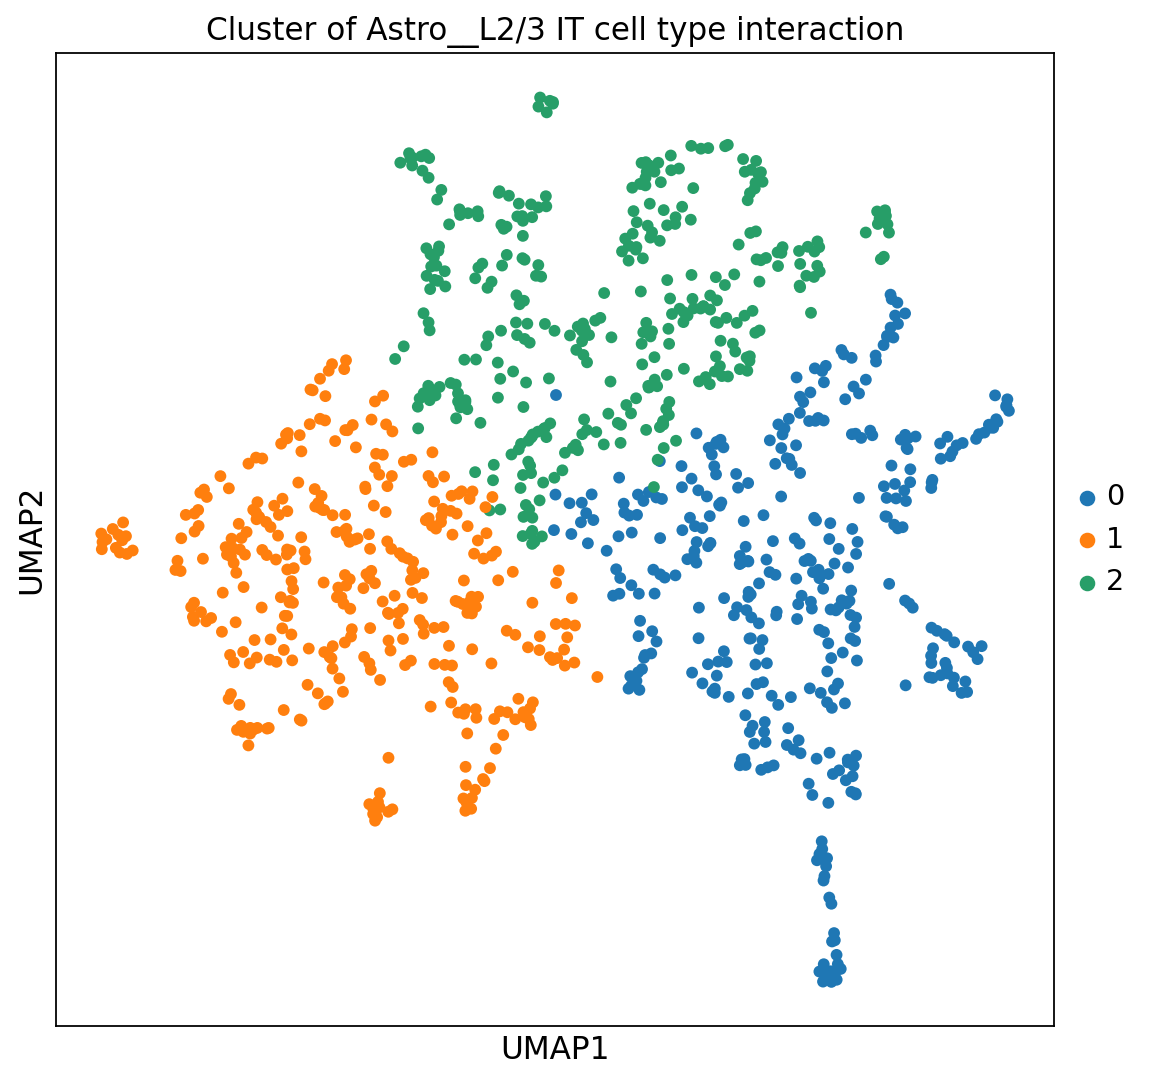

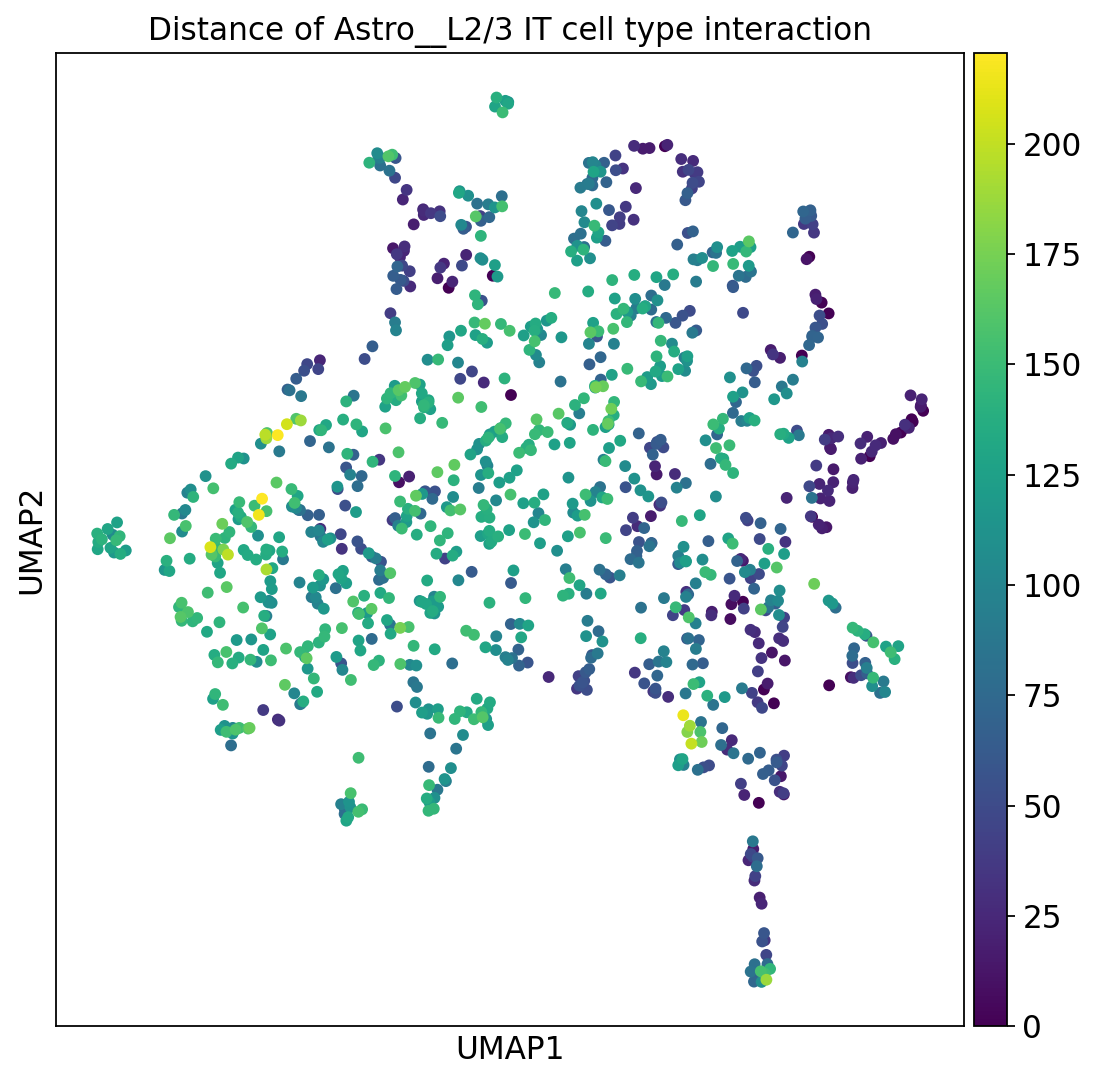

In [20]:
def cluster_and_plot(adata_original,desired_CCC_type):
    adata=adata_original.copy()
    sc.pp.scale(adata)
    # PCA
    sc.tl.pca(adata,n_comps=40)
    # Neighborhood Graph
    sc.pp.neighbors(adata, n_neighbors=10)
    # Clustering
    sc.tl.leiden(adata,resolution=0.09)  # or sc.tl.louvain(adata)
    # Visualization
    sc.tl.umap(adata)
    sc.pl.umap(adata, color='leiden',title="Cluster of "+desired_CCC_type+" cell type interaction")
    sc.pl.umap(adata, color='distance',title="Distance of "+desired_CCC_type+" cell type interaction")
    return np.array(adata.obs['leiden'].values)
leiden=cluster_and_plot(adata_type[adata_type.obs["is_target_interaction"]],desired_CCC_type)

In [21]:
def merge_group(adata_type,groups):
    groups1=[]
    cnt=0
    for i in range(len(adata_type.obs["is_target_interaction"])):
        if adata_type.obs["is_target_interaction"][i]==False:
            groups1.append("-1")
        else:
            groups1.append(groups[cnt])
            cnt=cnt+1
    assert cnt==len(groups)
    adata_type.obs["group"]=groups1
    return adata_type

adata_type=merge_group(adata_type,leiden)
print(adata_type)

AnnData object with n_obs × n_vars = 3525 × 254
    obs: 'cell_type', 'cell_types_from', 'cell_type_target', 'from_position_x', 'from_position_y', 'to_position_x', 'to_position_y', 'distance', 'loss', 'is_target_interaction', 'is_target_interaction_str', 'group'
    obsm: 'y', 'attention_score'


/tmp/ipykernel_167492/1162171487.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adata_type.obs["is_target_interaction"][i]==False:


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_utils.py:715: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


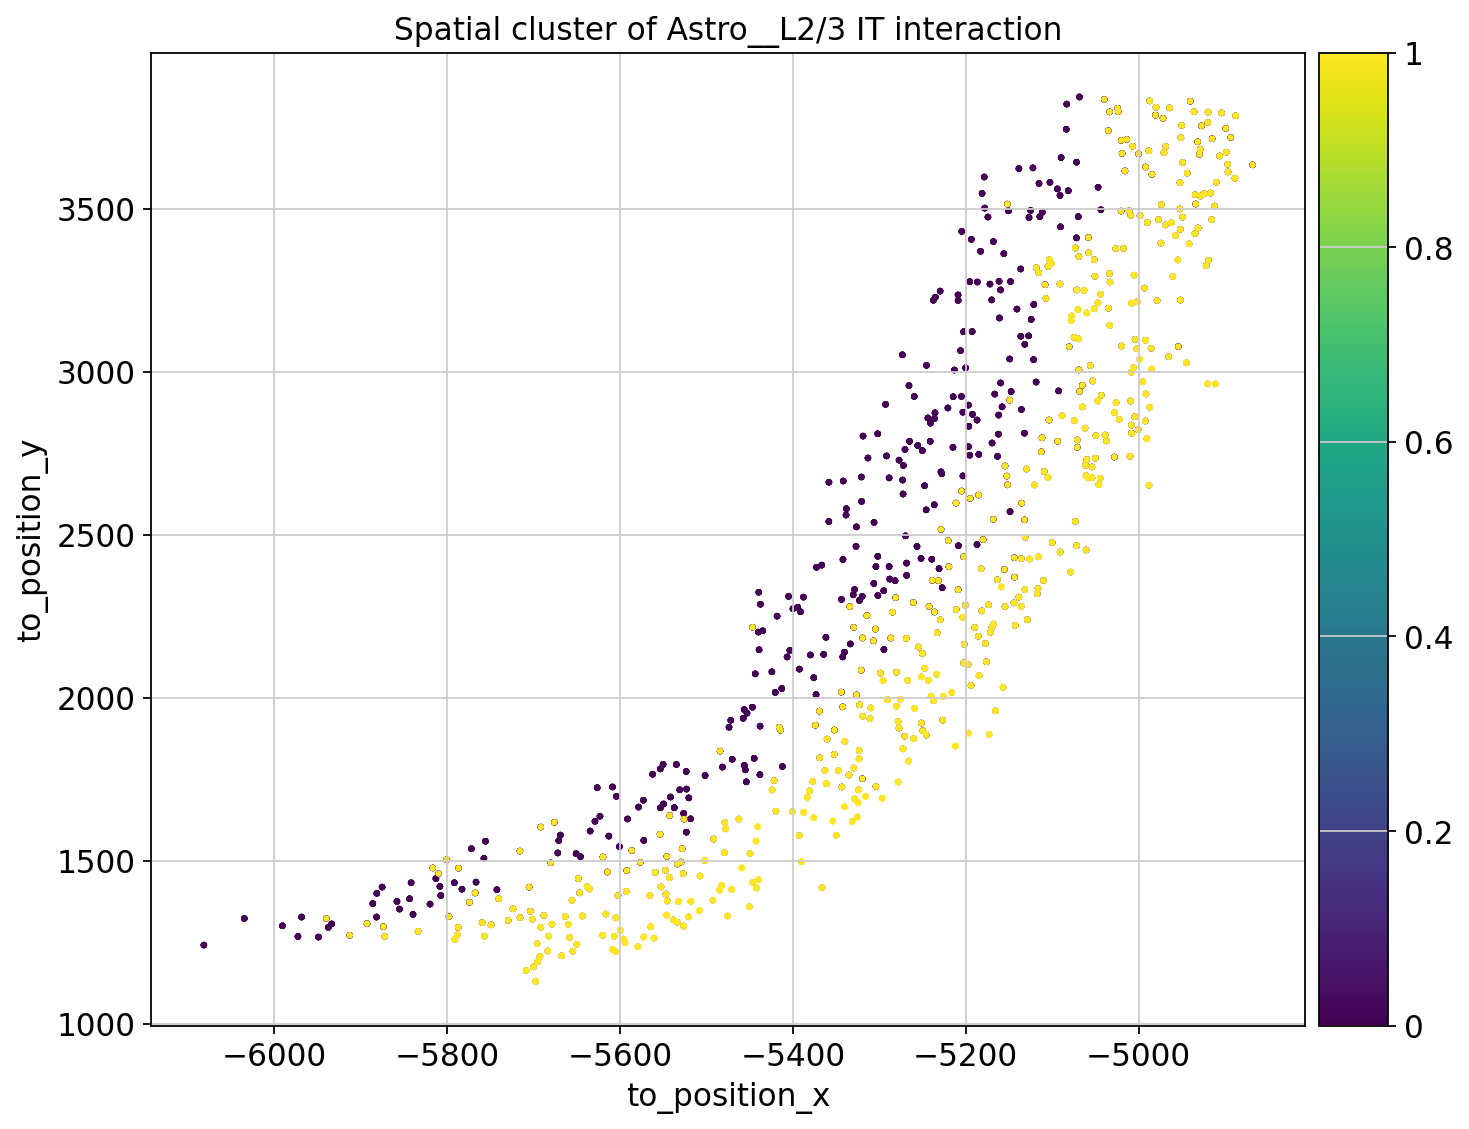

/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


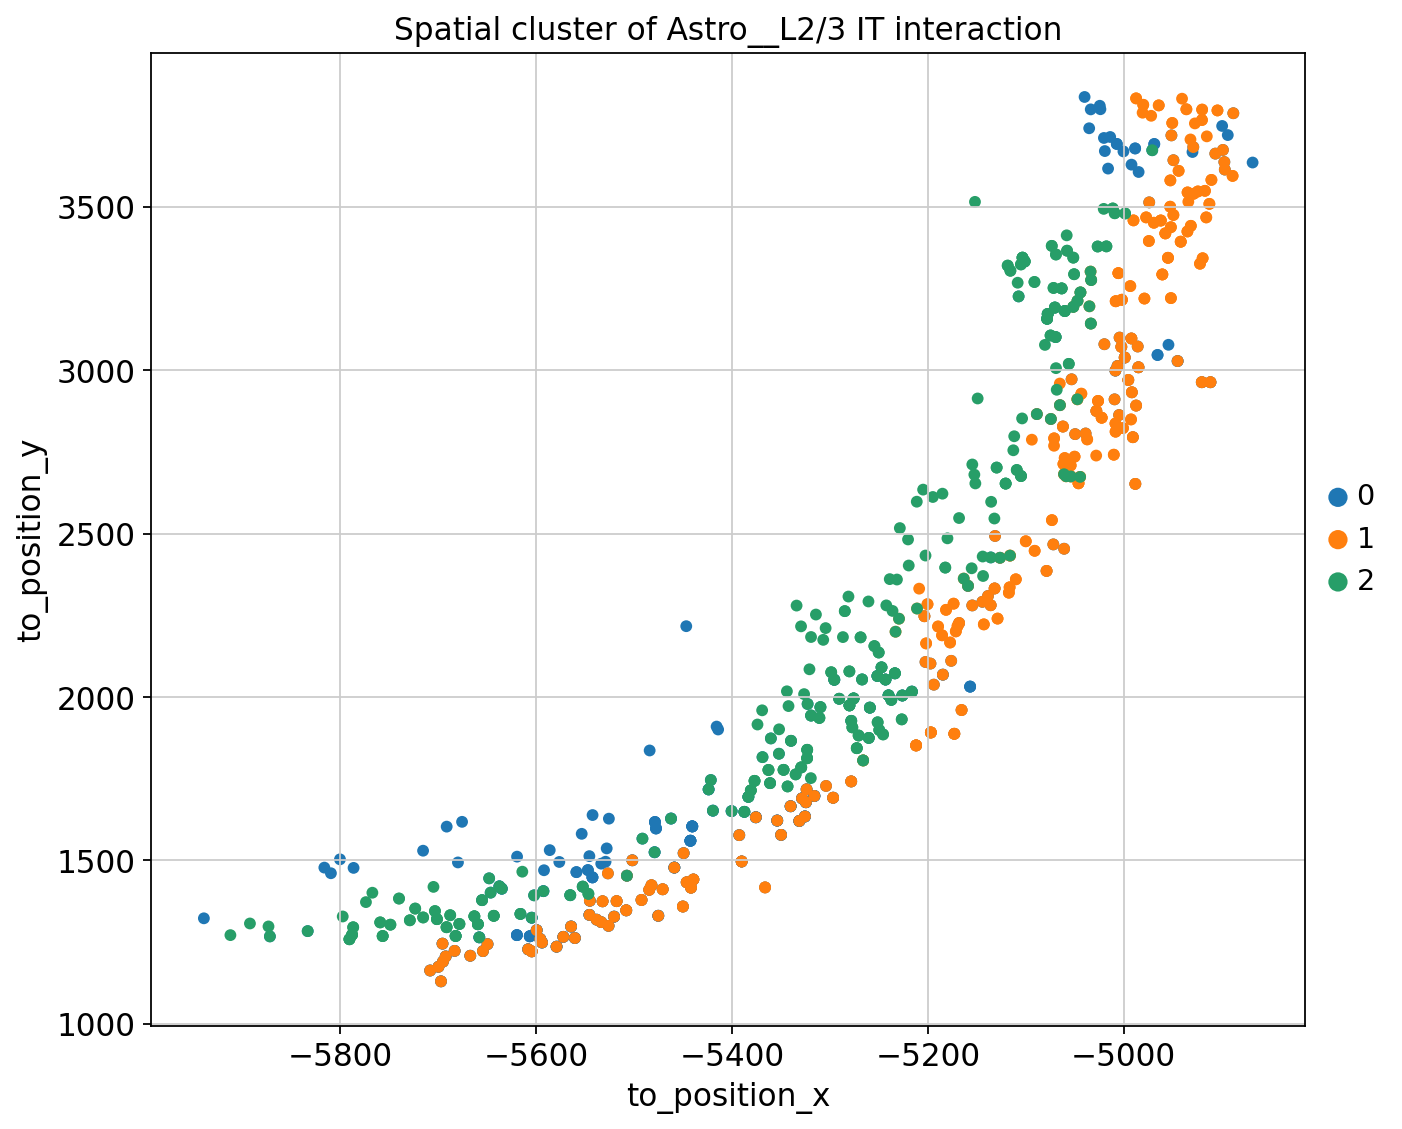

In [22]:
def spatial_visualize_type(adata,interaction_name):
    sc.set_figure_params(figsize=(8, 8))  # Adjust figure size as needed
    sc.pl.scatter(
        adata,
        x='to_position_x',#'position_x',
        y='to_position_y',#'position_y',
        color="is_target_interaction",
        title=f"Spatial cluster of {interaction_name} interaction"
    )
    
    adata1=adata[adata.obs["is_target_interaction"]]
    sc.set_figure_params(figsize=(8, 8))  # Adjust figure size as needed
    sc.pl.scatter(
        adata1,
        x='to_position_x',#'position_x',
        y='to_position_y',#'position_y',
        color='group',
        title=f"Spatial cluster of {interaction_name} interaction"
    )
spatial_visualize_type(adata_type,desired_CCC_type)

In [23]:
def filter_same_target_cell(adata_type):
    unique_y=[]
    group_y=[]
    
    useful_index=[]
    
    for i in range(adata_type.shape[0]):
        if len(unique_y)==0:
            unique_y.append(adata_type.obsm["y"][i,:])
            group_y.append(adata_type.obs["group"][i])
            useful_index.append(i)
            continue
        if np.sum(adata_type.obsm["y"][i,:]-unique_y[-1])==0:
            groupi=adata_type.obs["group"][i]
            if int(groupi)>int(group_y[-1]):
                group_y[-1]=groupi
                useful_index[-1]=i
            continue
        unique_y.append(adata_type.obsm["y"][i,:])
        group_y.append(adata_type.obs["group"][i])
        useful_index.append(i)
    
    adata_new=adata_type[np.array(useful_index)]
    adata_new.obs["group"]=group_y
    return adata_new        

adata_type1=filter_same_target_cell(adata_type)
print(adata_type,adata_type1)

/tmp/ipykernel_167492/1447732081.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  group_y.append(adata_type.obs["group"][i])
/tmp/ipykernel_167492/1447732081.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  groupi=adata_type.obs["group"][i]
/tmp/ipykernel_167492/1447732081.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  group_y.append(adata_type.obs["group"][i])


AnnData object with n_obs × n_vars = 3525 × 254
    obs: 'cell_type', 'cell_types_from', 'cell_type_target', 'from_position_x', 'from_position_y', 'to_position_x', 'to_position_y', 'distance', 'loss', 'is_target_interaction', 'is_target_interaction_str', 'group'
    obsm: 'y', 'attention_score' AnnData object with n_obs × n_vars = 705 × 254
    obs: 'cell_type', 'cell_types_from', 'cell_type_target', 'from_position_x', 'from_position_y', 'to_position_x', 'to_position_y', 'distance', 'loss', 'is_target_interaction', 'is_target_interaction_str', 'group'
    obsm: 'y', 'attention_score'


/tmp/ipykernel_167492/1447732081.py:24: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_new.obs["group"]=group_y


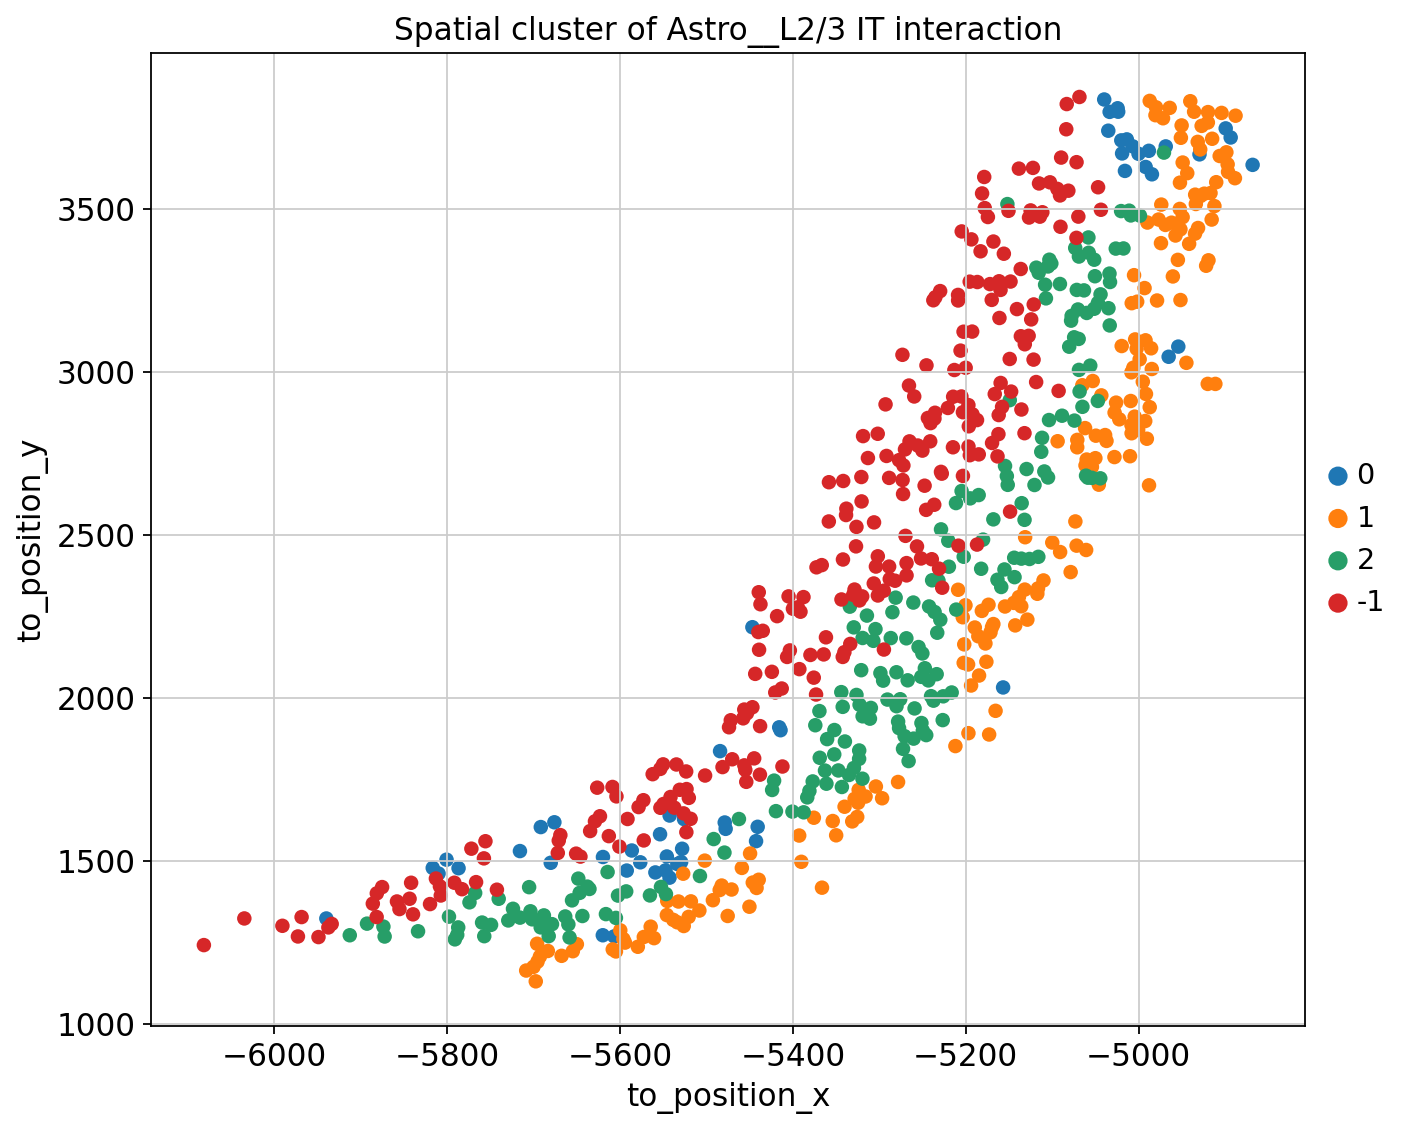

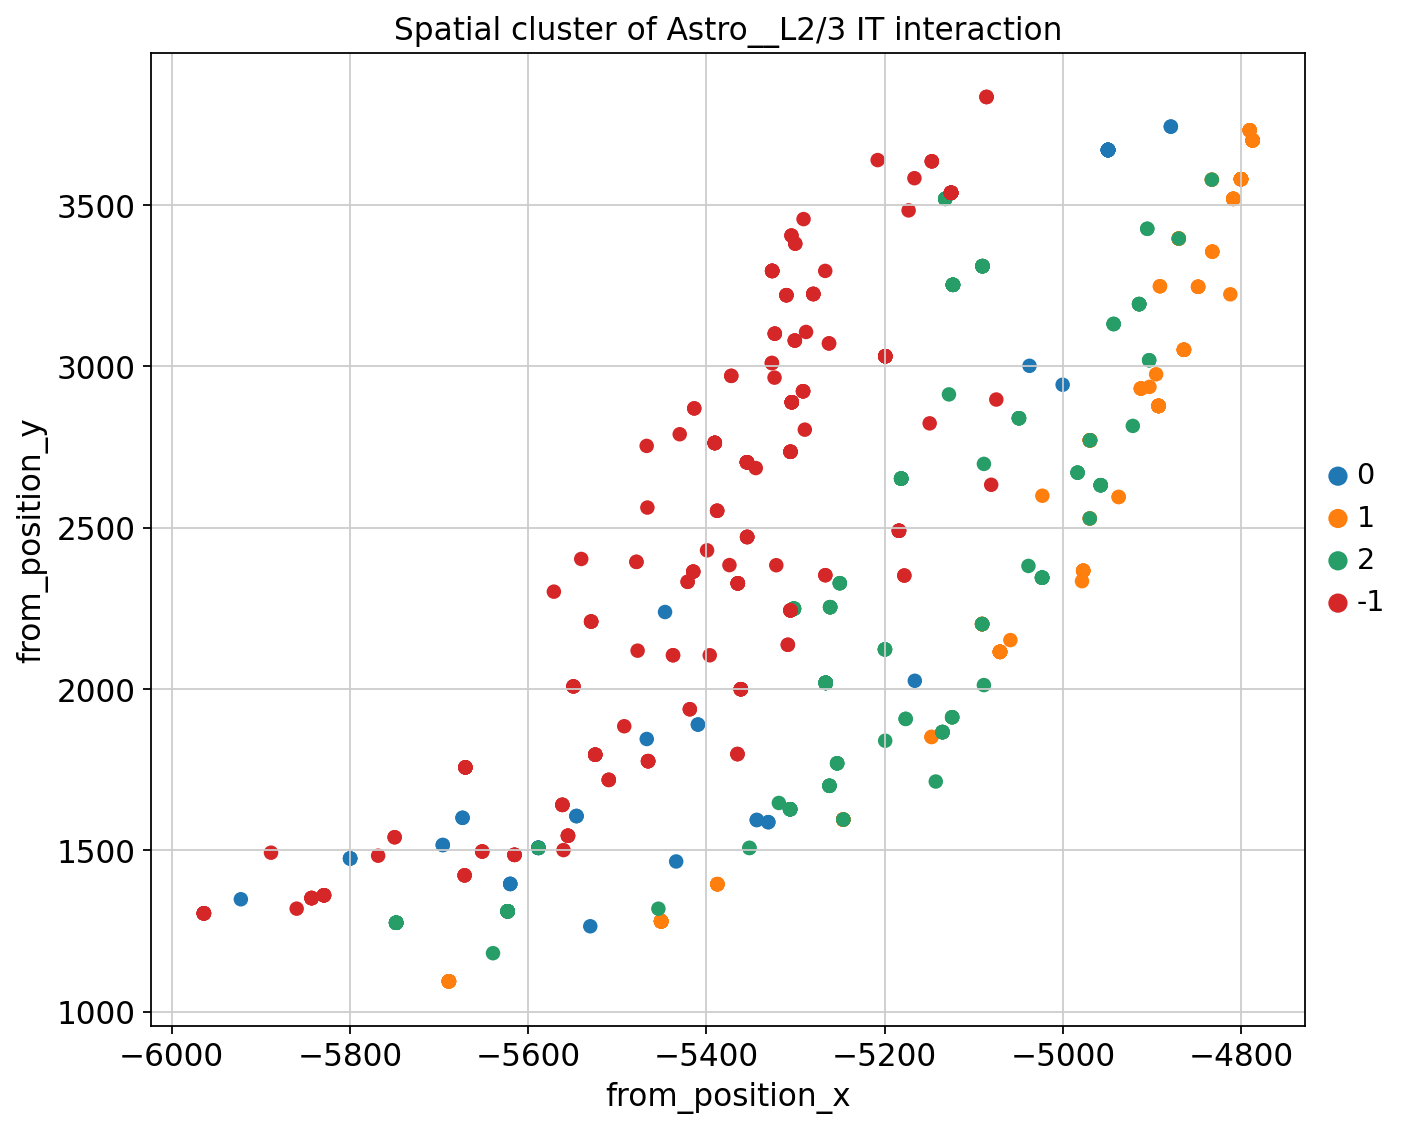

In [24]:
def spatial_visualize_type1(adata,interaction_name):
    sc.set_figure_params(figsize=(8, 8))  # Adjust figure size as needed
    sc.pl.scatter(
        adata,
        x='to_position_x',#'position_x',
        y='to_position_y',#'position_y',
        color="group",
        title=f"Spatial cluster of {interaction_name} interaction"
    )
    sc.pl.scatter(
        adata,
        x='from_position_x',#'position_x',
        y='from_position_y',#'position_y',
        color="group",
        title=f"Spatial cluster of {interaction_name} interaction"
    )
spatial_visualize_type1(adata_type1,desired_CCC_type)

AnnData object with n_obs × n_vars = 454 × 254
    obs: 'cell_type', 'cell_types_from', 'cell_type_target', 'from_position_x', 'from_position_y', 'to_position_x', 'to_position_y', 'distance', 'loss', 'is_target_interaction', 'is_target_interaction_str', 'group'
         Falling back to preprocessing with `sc.pp.pca` and default params.


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


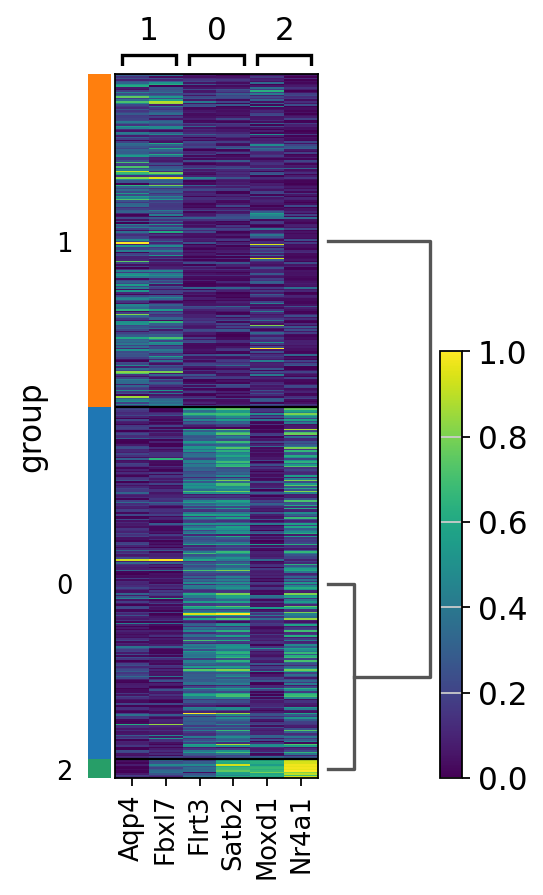

AnnData object with n_obs × n_vars = 454 × 254
    obs: 'cell_type', 'cell_types_from', 'cell_type_target', 'from_position_x', 'from_position_y', 'to_position_x', 'to_position_y', 'distance', 'loss', 'is_target_interaction', 'is_target_interaction_str', 'group'
    uns: 'rank_genes_groups', 'group_colors', 'dendrogram_group'
    obsm: 'X_pca'
         Falling back to preprocessing with `sc.pp.pca` and default params.


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/tools/_dendr

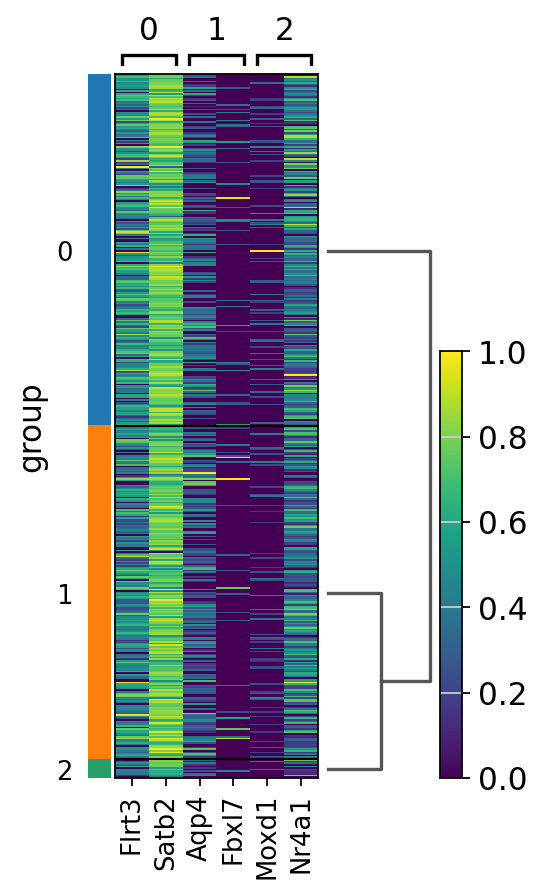

In [19]:
import anndata as ad

genes = torch.load("/".join(data_dir.split("/")[:-2]) + "/genes.pth")

adata_type_attention=ad.AnnData(X=np.abs(adata_type1.obsm["attention_score"]), obs=adata_type1.obs)
adata_type_attention=adata_type_attention[adata_type_attention.obs["group"]!="-1"]
adata_type_attention.var_names=genes
print(adata_type_attention)
# Example: Using Scanpy for differential expression
#"is_target_interaction_str"
sc.tl.rank_genes_groups(adata_type_attention, 'group', method='t-test')#sc.tl.rank_genes_groups(adata_type_attention, 'group', method='t-test')
# View the top 5 genes for each cluster
sc.pl.rank_genes_groups_heatmap(adata_type_attention, n_genes=2, show_gene_labels=True,standard_scale='var', cmap='viridis')
print(adata_type_attention)

adata_type_y=ad.AnnData(X=adata_type1.obsm["y"], obs=adata_type1.obs)
adata_type_y=adata_type_y[adata_type_y.obs["group"]!="-1"]
adata_type_y.var_names=genes
sc.tl.rank_genes_groups(adata_type_y, 'group', method='t-test')
adata_type_y.uns['rank_genes_groups']=adata_type_attention.uns['rank_genes_groups']
sc.pl.rank_genes_groups_heatmap(adata_type_y, n_genes=2, show_gene_labels=True,standard_scale='var', cmap='viridis')